# Libraires needed

In [1]:
import numpy as np
import pandas as pd
import warnings
from math import tau
from numpy import interp
from scipy.integrate import quad
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

## Functions

In [3]:
def onlyBlackWhite(array, threshold = 0.5):
    result = array.copy()
    for i in range(len(result)):
        for j in range(len(result[0])):
            if (result[i,j] < threshold):
                result[i,j] = 0
            else:
                result[i,j] = 1
    return result

In [4]:
def create_close_loop(image_array, level=[200]):

    # Get Contour Path and create lookup-table
    contour_path = plt.contour(image_array, levels=level, colors='black', origin='image').collections[0].get_paths()[0]
    x_table, y_table = contour_path.vertices[:, 0], contour_path.vertices[:, 1]
    time_table = np.linspace(0, tau, len(x_table))

    # Simple method to center the image
    x_table = x_table - min(x_table)
    y_table = y_table - min(y_table)
    x_table = x_table - max(x_table) / 2
    y_table = y_table - max(y_table) / 2

    return time_table, x_table, y_table

In [5]:
def f(t, time_table, x_table, y_table):
    return interp(t, time_table, x_table) + 1j*interp(t, time_table, y_table)

def coef_list(time_table, x_table, y_table, order=10):
    """
    Counting c_n coefficients of Fourier series, of function aproximated by points (time_table, x_table + j*y_table)
    of order of magnitude = order
    """
    coef_list = []
    for n in range(-order, order+1):
        real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        coef_list.append([real_coef, imag_coef])
    return np.array(coef_list)

## Preparing to generate

In [6]:
threshhold_options = [0.5, 0.6, 0.7, 0.8, 0.9]
# order = 10 as default, bigger results in big time complexity
set_name = './SETS/Fourier_depth_10_th_'
i_compare = np.linspace(0, len(data)-1, len(data)).astype(int)

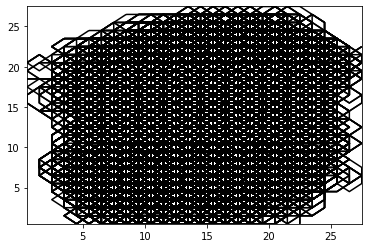

In [7]:
for th in threshhold_options:
    coef_data = []
    for i in i_compare:
        copied = onlyBlackWhite(data[i,:,:], threshold=th)
        time_table, x_table, y_table = create_close_loop(copied)
        coef = coef_list(time_table, x_table, y_table, order=10)
        coef_data.append(coef)
    curr_name = set_name + str(th)
    np.save(file=curr_name, arr=coef_data)